# Table of Contents

1. [Overview](#Overview)

    a. [Business problem](#Business-problem)

    b. [Data sources](#Data-sources)
    
    c. [Process summary](#Process-summary)

2. [Data pre-processing](#Data-pre-processing)

    a. [Data import and inspection](#Data-import-and-insepction)
    
    b. [Outlier detection](#Outlier-detection)

    c. [Feature engineering](#Feature-engineering)

2. [Independent-samples t-tests](#Independent-samples-t-tests)

    a. [Assessing prices between houses that have vs. have not been renovated](#Assessing-prices-between-houses-that-have-vs.-have-not-been-renovated)
    
    b. [Assessing prices between houses that have vs. do not have a waterfront view](#Assessing-prices-between-houses-that-have-vs.-do-not-have-a-waterfront-view)

    c. [Assessing prices between houses that have vs. do not have a basement](#Assessing-prices-between-houses-that-have-vs.-do-not-have-a-basement)

3. [Assessing linearity between price and prospective predictors](#Assessing-linearity-between-price-and-prospective-predictors)


4. [Model iteration 1](#Model-iteration-1)

    a. [Regression diagnostics](#Regression-diagnostics)
    
    b. [One-hot encoding categorical variables](#One-hot-encoding-categorical-variables)


5. [Model iteration 2](#Model-iteration-2)

    a. [Data standardisation and transformation](#Data-standardisation-and-transformation)

6. [Model iteration 3](#Model-iteration-3)

7. [Model validation](#Model-validation)

8. [Results](#Results)

9. [Conclusion](#Conclusion)

10. [Next steps](#Next-steps)

# Overview

Multiple linear regression was utilised to predict prices of houses sold between the years 2014 - 2015 in King County, Washington State, USA. Through six predictors (Number of bedrooms, number of bathrooms, number of floors, basement size, building grade, and zipcode), the regression model accounted for ~76% of the variability in house prices. Model improvement suggestions are presented, both in the context of more advanced statistical modelling techniques, as well as further house and neighbourhood characteristics to be collected and analysed.

___

## Business problem

There are numerous factors to consider when attempting to sell a home (as if the competitive state of the real estate market wasn't stressful enough). While the consequences of underestimating your home's market value are obvious, overestimations would on the other hand hinder a lot's performance on the market. 

__[Independent home valuations](https://www.nsw.gov.au/housing-and-construction/property-acquisition/valuations-and-compensation/getting-your-property-valued#toc-getting-your-own-valuation
)__ are commonly used for sellers to assess their property's market value - although with every professional service, valuations do incur a fee. Banks and real estate agencies are increasingly offering __[free online appraisal tools](https://www.realestate.com.au/property/?campaignType=external&campaignChannel=sem&campaignSource=google&campaignName=track_property&campaignKeyword=generic_appraisal&gad=1&gclid=Cj0KCQjw06-oBhC6ARIsAGuzdw0iPECUhALTOHU1N5M5rihmsvDhWZUMvhSwRB6SIuEbcJWXgki0_d4aAq6jEALw_wcB)__, which are helpful in allowing sellers to have a more informed position prior to taking the next steps before formally listing their house on the market. 


Through multiple linear regression, the current project aims to replicate the functionality of commercial home appraisal tools by taking into account a number of readily-known factors (e.g., number of bedrooms and bathrooms, home zip code). The model is built on a dataset of houses sold between 2014 - 2015 in King County, Washington State, USA.

___

## Data sources

**King County House Data** (`kc_house_data.csv`) contains the following information from homes that were sold between 2014 - 2015: 
- id: unique house identifier
- date: when the house was sold
- price: house sale price
- bedrooms: number of bedrooms
- bathrooms: number of bathrooms
- sqft_living: square footage of the house
- sqft_lot: square footage of the lot
- floors: number of floors in the house
- waterfront: whether the house has a waterfront view
- view: whether the house has been viewed
- condition: the overall condition (level of maintenance) of the house
- grade: the overall grade (level of improvements) of the house
- sqft_above: square footage of the house, excluding the basement
- sqft_basement: square footage of the basement
- zipcode: zip code, used by the United States Postal Service

___

## Process summary

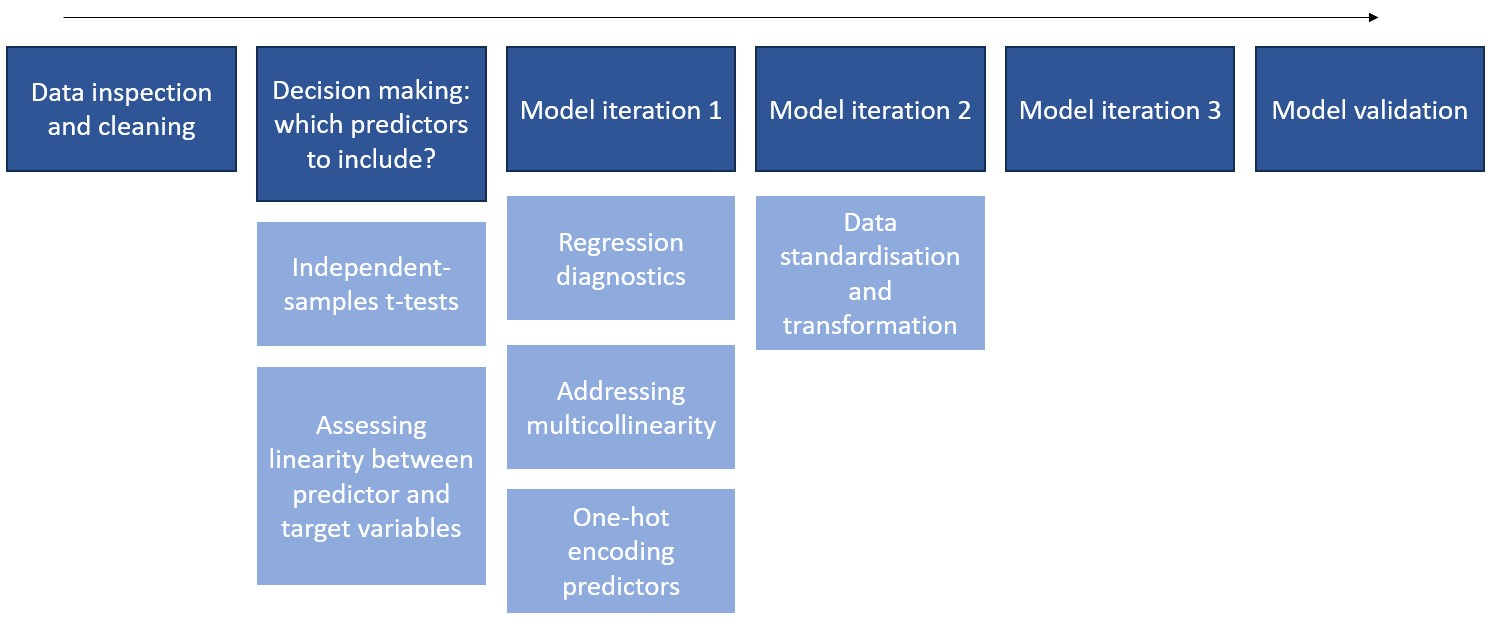

___

# Data pre-processing

## Data import and inspection

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from scipy import stats

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

%matplotlib inline

In [3]:
# reading in the data
filepath = r'.\data'
houses_df = pd.read_csv(filepath + r'\kc_house_data.csv', parse_dates=['date'])

In [4]:
# previewing the dataset
houses_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2420069251,2015-02-25,262000,1,0.75,520,12981,1.0,0.0,0.0,...,3,520,0,1920,0.0,98022,47.2082,-121.995,1340,12233
1,7325600160,2014-06-04,299000,1,0.75,560,12120,1.0,NaN,0.0,...,4,560,0,1967,0.0,98014,47.6750,-121.854,1300,19207
2,8658300340,2014-05-23,80000,1,0.75,430,5050,1.0,NaN,0.0,...,4,430,0,1912,0.0,98014,47.6499,-121.909,1200,7500
3,3340401535,2014-11-05,140000,1,1.00,730,6890,1.0,0.0,0.0,...,4,730,0,1926,0.0,98055,47.4670,-122.215,1790,7969
4,1925069006,2014-12-03,355000,1,0.75,530,33278,1.0,0.0,2.0,...,4,530,0,1950,0.0,98074,47.6412,-122.079,2830,14311


In [5]:
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  int64         
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  float64       
 9   view           21534 non-null  float64       
 10  condition      21597 non-null  int64         
 11  grade          21597 non-null  int64         
 12  sqft_above     21597 non-null  int64         
 13  sqft_basement  21597 non-null  object        
 14  yr_built       21597 non-null  int64         
 15  yr_renovated   1775

#### `sqft_basement` was imported as a *string* instead of an integer type column, which warrants further inspection

#### `zipcode` will be treated as a categorical column

#### both of these points will be addressed later

____

### dropping non-important columns 

the following columns were assessed to be redundant (e.g., `condition`, which provides similar information to `grade`) or non-important: 
- sqft_lot
- view
- condition
- sqft_above
- lat
- long
- sqft_living15
- sqft_lot15

In [6]:
houses_df.drop(columns=['view', 'condition', 'sqft_above',
                      'lat', 'long', 'sqft_living15', 'sqft_lot15'], inplace=True)

In [7]:
# confirming columns were dropped
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             21597 non-null  int64         
 1   date           21597 non-null  datetime64[ns]
 2   price          21597 non-null  int64         
 3   bedrooms       21597 non-null  int64         
 4   bathrooms      21597 non-null  float64       
 5   sqft_living    21597 non-null  int64         
 6   sqft_lot       21597 non-null  int64         
 7   floors         21597 non-null  float64       
 8   waterfront     19221 non-null  float64       
 9   grade          21597 non-null  int64         
 10  sqft_basement  21597 non-null  object        
 11  yr_built       21597 non-null  int64         
 12  yr_renovated   17755 non-null  float64       
 13  zipcode        21597 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(8), object(1)
memory usage: 2.

___

### inspecting missing values

In [8]:
# create table of missing values per column
missing_counts = houses_df.isnull().agg('sum').reset_index()
missing_counts.columns = ['variable', 'n_missing']
missing_counts = missing_counts.sort_values('n_missing', ascending=False)

missing_counts

,variable,n_missing
12,yr_renovated,3842
8,waterfront,2376
0,id,0
1,date,0
2,price,0
3,bedrooms,0
4,bathrooms,0
5,sqft_living,0
6,sqft_lot,0
7,floors,0


#### no missing data for target var (`price`)

#### a lot of null values for `waterfront` and `yr_renovated`, though both would be valid (i.e., not all houses are built with a waterfront, and not all houses were renovated prior to being sold)

In [9]:
# replace null values with 0
houses_df['yr_renovated'].fillna(0, inplace=True)
houses_df['waterfront'].fillna(0, inplace=True)

In [10]:
# confirming no more null values
missing_counts = houses_df.isnull().agg('sum').reset_index()
missing_counts.columns = ['variable', 'n_missing']
missing_counts = missing_counts.sort_values('n_missing', ascending=False)

missing_counts

,variable,n_missing
0,id,0
1,date,0
2,price,0
3,bedrooms,0
4,bathrooms,0
5,sqft_living,0
6,sqft_lot,0
7,floors,0
8,waterfront,0
9,grade,0


In [11]:
# inspecting sqft_basement; why was it imported as a string?
houses_df['sqft_basement'].value_counts()

0       12826
?         454
600       217
500       209
700       208
        ...  
225         1
176         1
516         1
602         1
3480        1
Name: sqft_basement, Length: 304, dtype: int64

In [12]:
# all instances of '?' will be replaced with a 0
# sqft_basement will then be converted to an int dtype
houses_df['sqft_basement'].replace('?', '0', inplace=True)
houses_df['sqft_basement'] = houses_df['sqft_basement'].astype('int64')

In [13]:
# change zipcode dtype to string 
houses_df['zipcode'] = houses_df['zipcode'].astype('object')

In [14]:
# creating a new column, 'zipcode_cat', which will be used in model iteration 1
houses_df['zipcode_cat'] = houses_df['zipcode'].astype('category').cat.codes

In [15]:
houses_df[['zipcode', 'zipcode_cat']]

,zipcode,zipcode_cat
0,98022,12
1,98014,10
2,98014,10
3,98055,30
4,98074,37
...,...,...
21592,98006,5
21593,98177,65
21594,98006,5
21595,98177,65


____

## Outlier detection

### target variable

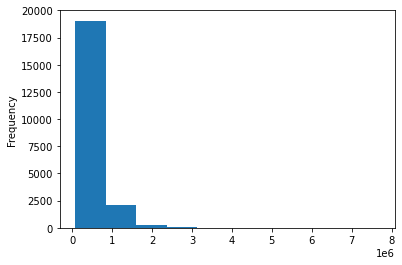

In [16]:
# inspecting distribution
houses_df['price'].plot.hist()
plt.show()

C:\Users\arina\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


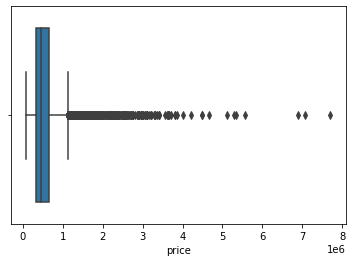

In [17]:
sns.boxplot(houses_df['price'])
plt.show() # ignore FutureWarning

In [18]:
# calculating the interquartile range (IQR)
Q1 = houses_df['price'].quantile(0.25)
Q3 = houses_df['price'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR
 
# identifying the outliers
upper_array = np.where(houses_df['price']>=upper)[0]
lower_array = np.where(houses_df['price']<=lower)[0]

In [19]:
# removing the outliers
houses_df.drop(index=upper_array, inplace=True)
houses_df.drop(index=lower_array, inplace=True)

# return the new shape of the dataset
print("Total number of rows: ", houses_df.shape[0])

Total number of rows:  20439


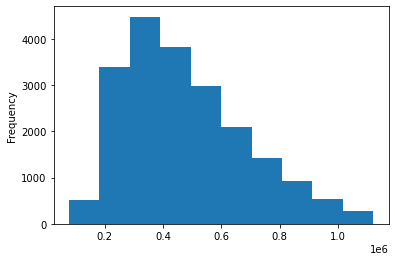

In [20]:
# inspecting distribution
houses_df['price'].plot.hist()
plt.show()

C:\Users\arina\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


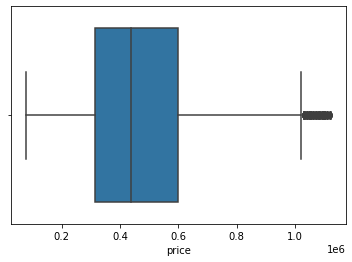

In [21]:
sns.boxplot(houses_df['price'])
plt.show() # ignore FutureWarning

___

### Predictor variables

Prospective predictors:
- bedrooms
- bathrooms
- sqft_living
- sqft_lot
- sqft_basement
- floors
- waterfront
- grade
- yr_built
- yr_renovated
- zipcode

In [22]:
houses_df['grade'].value_counts()

7     8962
8     5943
9     2319
6     2037
10     766
5      242
11     137
4       27
12       5
3        1
Name: grade, dtype: int64

In [23]:
houses_df['waterfront'].value_counts()

0.0    20388
1.0       51
Name: waterfront, dtype: int64

In [24]:
houses_df['floors'].value_counts()

1.0    10439
2.0     7486
1.5     1828
3.0      570
2.5      110
3.5        6
Name: floors, dtype: int64

In [25]:
houses_df['zipcode'].value_counts()

98103    588
98038    586
98052    563
98115    558
98042    547
        ... 
98102     88
98109     86
98024     73
98148     57
98039      6
Name: zipcode, Length: 70, dtype: int64

#### very low number of houses sold in zipcode 98039 (Medina, Washington). however, this is valid - Medina is the most expensive area in King County (and one of the most expensive in the US)

In [26]:
houses_df['bedrooms'].value_counts()

3     9597
4     6304
2     2736
5     1335
6      225
1      195
7       30
8        9
9        4
10       2
11       1
33       1
Name: bedrooms, dtype: int64

In [27]:
houses_df[(houses_df.bedrooms==33) | (houses_df.bedrooms==11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_basement,yr_built,yr_renovated,zipcode,zipcode_cat
6088,1773100755,2014-08-21,520000,11,3.00,3000,4960,2.0,0.0,7,600,1918,1999.0,98106,44
9262,2402100895,2014-06-25,640000,33,1.75,1620,6000,1.0,0.0,7,580,1947,0.0,98103,42


#### 11 and 33 bedrooms were probably errors. `sqft_living` values are way too small to have 11/33 bedrooms at a grade 7. these rows will be dropped

In [28]:
houses_df.drop(index=[6088, 9262], inplace=True)

In [29]:
houses_df[(houses_df.bedrooms==9) | (houses_df.bedrooms==10)].sort_values(by='bedrooms')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_basement,yr_built,yr_renovated,zipcode,zipcode_cat
4101,1997200215,2014-05-07,599999,9,4.5,3830,6988,2.5,0.0,7,1380,1938,0.0,98103,42
4161,2902200015,2015-01-06,700000,9,3.0,3680,4400,2.0,0.0,7,850,1908,0.0,98102,41
5996,424049043,2014-08-11,450000,9,7.5,4050,6504,2.0,0.0,7,0,1996,0.0,98144,59
10354,8823901445,2015-03-13,934000,9,3.0,2820,4480,2.0,0.0,7,940,1918,0.0,98105,43
8938,5566100170,2014-10-29,650000,10,2.0,3610,11914,2.0,0.0,7,600,1958,0.0,98006,5
10704,8812401450,2014-12-29,660000,10,3.0,2920,3745,2.0,0.0,7,1060,1913,0.0,98105,43


#### the rows associated with 9 and 10 bedrooms seem valid, and there's no reason to remove these

In [30]:
houses_df['bathrooms'].value_counts()

2.50    5194
1.00    3849
1.75    3014
2.25    1958
2.00    1909
1.50    1435
2.75    1107
3.00     664
3.50     542
3.25     425
3.75      83
4.00      75
0.75      71
4.50      51
4.25      28
5.00       8
1.25       7
4.75       5
0.50       4
5.25       3
7.50       1
5.75       1
6.75       1
5.50       1
6.00       1
Name: bathrooms, dtype: int64

In [31]:
houses_df[houses_df.bathrooms>=6.25].sort_values(by='bathrooms')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,grade,sqft_basement,yr_built,yr_renovated,zipcode,zipcode_cat
21167,9175600025,2014-10-07,800000,7,6.75,7480,41664,2.0,0.0,11,2400,1953,0.0,98166,63
5996,424049043,2014-08-11,450000,9,7.50,4050,6504,2.0,0.0,7,0,1996,0.0,98144,59


#### the high number of bathrooms also seems valid

In [32]:
houses_df.sort_values(by='sqft_living')['sqft_living']

218       370
39        380
2305      390
11        410
203       420
         ... 
21420    5820
17416    6050
21581    7120
21145    7350
21167    7480
Name: sqft_living, Length: 20437, dtype: int64

In [33]:
houses_df.sort_values(by='sqft_lot')['sqft_lot']

9204         520
4826         572
13337        600
19723        635
19948        638
          ...   
20156     982998
20344    1024068
13351    1074218
237      1164794
435      1651359
Name: sqft_lot, Length: 20437, dtype: int64

In [34]:
houses_df.sort_values(by='sqft_basement')['sqft_basement']

0           0
9890        0
9891        0
9892        0
9894        0
         ... 
18797    2250
18959    2300
21167    2400
21145    2600
18100    2720
Name: sqft_basement, Length: 20437, dtype: int64

In [35]:
houses_df.sort_values(by='yr_built')['yr_built']

10561    1900
1493     1900
14263    1900
8679     1900
3602     1900
         ... 
16986    2015
19701    2015
17426    2015
17197    2015
13316    2015
Name: yr_built, Length: 20437, dtype: int64

In [36]:
houses_df.sort_values(by='yr_renovated')['yr_renovated']

0           0.0
13612       0.0
13611       0.0
13610       0.0
13609       0.0
          ...  
15715    2015.0
18959    2015.0
13212    2015.0
12401    2015.0
12119    2015.0
Name: yr_renovated, Length: 20437, dtype: float64

#### the values for the rest of the columns seem valid

___

## Feature engineering

### creating columns to indicate the difference in years between when a house was sold and (1) when it was built, (2) when it was renovated

In [37]:
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20437 entries, 0 to 21581
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             20437 non-null  int64         
 1   date           20437 non-null  datetime64[ns]
 2   price          20437 non-null  int64         
 3   bedrooms       20437 non-null  int64         
 4   bathrooms      20437 non-null  float64       
 5   sqft_living    20437 non-null  int64         
 6   sqft_lot       20437 non-null  int64         
 7   floors         20437 non-null  float64       
 8   waterfront     20437 non-null  float64       
 9   grade          20437 non-null  int64         
 10  sqft_basement  20437 non-null  int64         
 11  yr_built       20437 non-null  int64         
 12  yr_renovated   20437 non-null  float64       
 13  zipcode        20437 non-null  object        
 14  zipcode_cat    20437 non-null  int8          
dtypes: datetime64[ns](1

In [38]:
# get year from date the house was sold
houses_df.insert(9, 'yr_sold', np.nan)
houses_df['yr_sold'] = houses_df['date'].dt.year

In [39]:
# calculate number of years since the house was built
houses_df.insert(12, 'yrs_since_built', np.nan)
houses_df['yrs_since_built'] = houses_df['yr_sold'] - houses_df['yr_built']

houses_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,yr_sold,grade,sqft_basement,yrs_since_built,yr_built,yr_renovated,zipcode,zipcode_cat
0,2420069251,2015-02-25,262000,1,0.75,520,12981,1.0,0.0,2015,3,0,95,1920,0.0,98022,12
1,7325600160,2014-06-04,299000,1,0.75,560,12120,1.0,0.0,2014,4,0,47,1967,0.0,98014,10
2,8658300340,2014-05-23,80000,1,0.75,430,5050,1.0,0.0,2014,4,0,102,1912,0.0,98014,10
3,3340401535,2014-11-05,140000,1,1.00,730,6890,1.0,0.0,2014,4,0,88,1926,0.0,98055,30
4,1925069006,2014-12-03,355000,1,0.75,530,33278,1.0,0.0,2014,4,0,64,1950,0.0,98074,37


In [40]:
# calculate the number of years since the house was renovated 
# 1. create Boolean column to identify houses that had been renovated 
houses_df.insert(2, 'had_renovations', np.nan)
houses_df['had_renovations'] = houses_df['yr_renovated'].apply(lambda x: True if x > 0 else False)

In [41]:
# 2. function to calculate diff in number of years between renovation and house being sold 
def diff_yrs(df):
    if df['had_renovations']==True:
        diff = df['yr_sold'] - df['yr_renovated']
    else:
        diff = np.nan
        
    return diff

In [42]:
# applying the function 
houses_df.insert(14, 'yrs_since_renovated', np.nan)
houses_df['yrs_since_renovated'] = houses_df.apply(diff_yrs, axis=1)
houses_df['yrs_since_renovated'].fillna(0, inplace=True)

In [43]:
houses_df[houses_df['had_renovations']==True].head()

,id,date,had_renovations,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,yr_sold,grade,sqft_basement,yrs_since_built,yrs_since_renovated,yr_built,yr_renovated,zipcode,zipcode_cat
12,4391600065,2014-08-14,True,330000,2,0.75,520,6862,1.0,0.0,2014,4,0,90,34.0,1924,1980.0,98010,8
132,3141600210,2014-06-19,True,186000,3,2.00,1340,4320,1.0,0.0,2014,5,420,102,21.0,1912,1993.0,98002,1
143,179001425,2014-10-24,True,230000,3,1.75,1420,3000,1.0,0.0,2014,5,710,83,0.0,1931,2014.0,98178,66
180,739000035,2015-01-16,True,291970,1,1.00,680,21727,1.0,0.0,2015,5,0,63,20.0,1952,1995.0,98058,32
219,3361400980,2015-05-12,True,135000,2,1.00,600,6120,1.0,0.0,2015,5,0,72,26.0,1943,1989.0,98168,64


In [44]:
houses_df[houses_df['had_renovations']==False].head()

,id,date,had_renovations,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,yr_sold,grade,sqft_basement,yrs_since_built,yrs_since_renovated,yr_built,yr_renovated,zipcode,zipcode_cat
0,2420069251,2015-02-25,False,262000,1,0.75,520,12981,1.0,0.0,2015,3,0,95,0.0,1920,0.0,98022,12
1,7325600160,2014-06-04,False,299000,1,0.75,560,12120,1.0,0.0,2014,4,0,47,0.0,1967,0.0,98014,10
2,8658300340,2014-05-23,False,80000,1,0.75,430,5050,1.0,0.0,2014,4,0,102,0.0,1912,0.0,98014,10
3,3340401535,2014-11-05,False,140000,1,1.00,730,6890,1.0,0.0,2014,4,0,88,0.0,1926,0.0,98055,30
4,1925069006,2014-12-03,False,355000,1,0.75,530,33278,1.0,0.0,2014,4,0,64,0.0,1950,0.0,98074,37


In [45]:
# 'date' column no longer required
houses_df.drop(columns='date', inplace=True)

In [46]:
houses_df.insert(3, 'has_basement', np.nan)
houses_df['has_basement'] = houses_df['sqft_basement'].apply(lambda x: True if x > 0 else False)

In [47]:
houses_df.insert(3, 'has_waterfront', np.nan)
houses_df['has_waterfront'] = houses_df['waterfront'].apply(lambda x: True if x > 0 else False)

In [48]:
houses_df[houses_df['has_waterfront']==True].head()

,id,had_renovations,price,has_waterfront,has_basement,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,yr_sold,grade,sqft_basement,yrs_since_built,yrs_since_renovated,yr_built,yr_renovated,zipcode,zipcode_cat
31,2123039032,False,369900,True,False,1,0.75,760,10079,1.0,1.0,2014,5,0,78,0.0,1936,0.0,98070,35
44,3523029041,False,290000,True,False,2,0.75,440,8313,1.0,1.0,2014,5,0,71,0.0,1943,0.0,98070,35
217,7936500221,False,658000,True,False,2,1.00,1010,14244,1.0,1.0,2015,5,0,89,0.0,1926,0.0,98136,58
258,2781600195,False,285000,True,False,1,1.00,1060,54846,1.0,1.0,2014,5,0,79,0.0,1935,0.0,98070,35
368,7567600045,False,825000,True,False,2,1.00,1150,12775,1.0,1.0,2014,6,0,106,0.0,1908,0.0,98178,66


In [49]:
houses_df[houses_df['has_waterfront']==False].head()

,id,had_renovations,price,has_waterfront,has_basement,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,yr_sold,grade,sqft_basement,yrs_since_built,yrs_since_renovated,yr_built,yr_renovated,zipcode,zipcode_cat
0,2420069251,False,262000,False,False,1,0.75,520,12981,1.0,0.0,2015,3,0,95,0.0,1920,0.0,98022,12
1,7325600160,False,299000,False,False,1,0.75,560,12120,1.0,0.0,2014,4,0,47,0.0,1967,0.0,98014,10
2,8658300340,False,80000,False,False,1,0.75,430,5050,1.0,0.0,2014,4,0,102,0.0,1912,0.0,98014,10
3,3340401535,False,140000,False,False,1,1.00,730,6890,1.0,0.0,2014,4,0,88,0.0,1926,0.0,98055,30
4,1925069006,False,355000,False,False,1,0.75,530,33278,1.0,0.0,2014,4,0,64,0.0,1950,0.0,98074,37


____

# Independent-samples t-tests

#### while some predictors would be more straightforward in how they may influence house prices (e.g., number of bedrooms, building grade), others may not be as obvious. Independent-samples t-tests were used to assess whether prices were significantly different between: 
- houses with vs. without prior renovations
- houses with vs. without a waterfront view
- houses with vs. without basements

## Assessing prices between houses that have vs. have not been renovated

In [50]:
# renovations vs. no renovations

# define groups 
reno_price = houses_df[houses_df.had_renovations==True]['price'].tolist()
no_reno_price = houses_df[houses_df.had_renovations==False]['price'].tolist()

# define alpha
alpha = 0.05

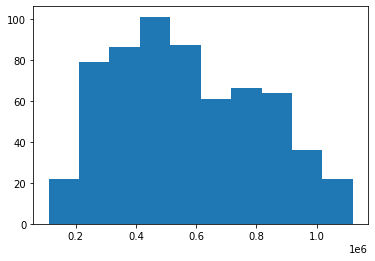

In [51]:
plt.hist(reno_price)
plt.show()

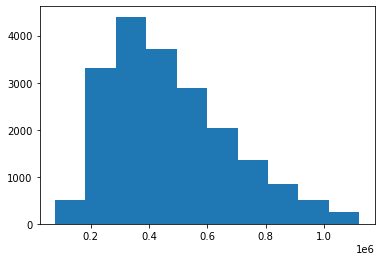

In [52]:
plt.hist(no_reno_price)
plt.show()

In [53]:
w_stats, p_value = stats.levene(reno_price, no_reno_price, center='median')

print(w_stats)
print("p-value: {}".format(p_value))

if p_value > alpha:
    print("Fail to reject null hypothesis; variances are equal")
else:
    print("Reject the null hypothesis; the variances are not equal")

49.35847006473533
p-value: 2.1991459125364626e-12
Reject the null hypothesis; the variances are not equal


In [54]:
# perform welch's t-test for renov. vs no renov.
print("Sample sizes")
print("Renovated houses:", len(reno_price))
print("Non-renovated houses:", len(no_reno_price))

print("Mean price of renovated houses: {}".format(sum(reno_price)/len(reno_price)))
print("Mean price of non-renovated houses: {}".format(sum(no_reno_price)/len(no_reno_price)))

Sample sizes
Renovated houses: 624
Non-renovated houses: 19813
Mean price of renovated houses: 571799.6923076923
Mean price of non-renovated houses: 473697.17306818755


In [55]:
stats.ttest_ind(reno_price, no_reno_price, equal_var=False, random_state=15)

Ttest_indResult(statistic=10.092567048083842, pvalue=2.3583629520537044e-22)

#### renovated houses appear to sell for significantly higher (by approximately 98K higher on average) 

____

## Assessing prices between houses that have vs. do not have a waterfront view

In [56]:
# waterfront vs. no waterfront

# define groups 
water_price = houses_df[houses_df.has_waterfront==True]['price'].tolist()
no_water_price = houses_df[houses_df.has_waterfront==False]['price'].tolist()

# define alpha
alpha = 0.05

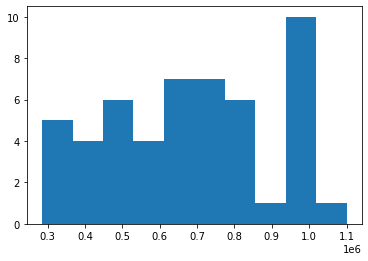

In [57]:
plt.hist(water_price)
plt.show()

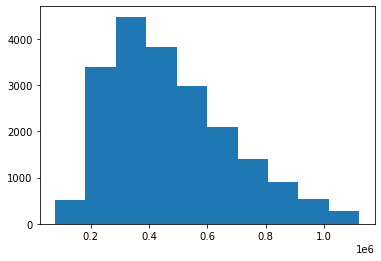

In [58]:
plt.hist(no_water_price)
plt.show()

In [59]:
w_stats, p_value = stats.levene(water_price, no_water_price, center='median')

print(w_stats)
print("p-value: {}".format(p_value))

if p_value > alpha:
    print("Fail to reject null hypothesis; variances are equal")
else:
    print("Reject the null hypothesis; the variances are not equal")

1.3355815208438202
p-value: 0.24782819327903302
Fail to reject null hypothesis; variances are equal


In [60]:
# perform student's t-test for waterfront vs. no waterfront
print("Sample sizes")
print("Houses with waterfronts:", len(water_price))
print("Houses without waterfronts:", len(no_water_price))

print("Mean price of houses with a waterfront: {}".format(sum(water_price)/len(water_price)))
print("Mean price of houses without a waterfront: {}".format(sum(no_water_price)/len(no_water_price)))

Sample sizes
Houses with waterfronts: 51
Houses without waterfronts: 20386
Mean price of houses with a waterfront: 680065.6862745098
Mean price of houses without a waterfront: 476183.7411949377


In [61]:
stats.ttest_ind(water_price, no_water_price, equal_var=True, random_state=15)

Ttest_indResult(statistic=7.006356427564125, pvalue=2.522105720594011e-12)

#### houses with a waterfront appear to sell for significantly higher (by approximately 20K higher on average)

____

## Assessing prices between houses that have vs. do not have a basement

In [62]:
# basement vs. no basement

# define groups 
base_price = houses_df[houses_df.has_basement==True]['price'].tolist()
no_base_price = houses_df[houses_df.has_basement==False]['price'].tolist()

# define alpha
alpha = 0.05

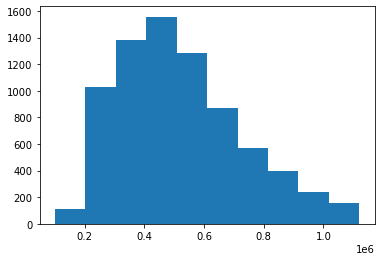

In [63]:
plt.hist(base_price)
plt.show()

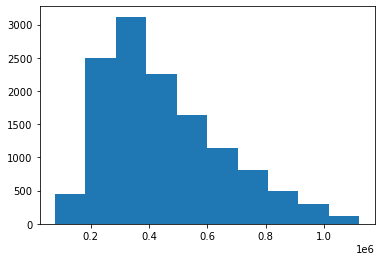

In [64]:
plt.hist(no_base_price)
plt.show()

In [65]:
w_stats, p_value = stats.levene(base_price, no_base_price, center='median')

print(w_stats)
print("p-value: {}".format(p_value))

if p_value > alpha:
    print("Fail to reject null hypothesis; variances are equal")
else:
    print("Reject the null hypothesis; the variances are not equal")

1.7819145839623913
p-value: 0.18192927352031035
Fail to reject null hypothesis; variances are equal


In [66]:
# perform student's t-test for base vs no base
print("Sample sizes")
print("Houses with basements:", len(base_price))
print("Houses without basements:", len(no_base_price))

print("Mean price of houses with a basement: {}".format(sum(base_price)/len(base_price)))
print("Mean price of houses without a basement: {}".format(sum(no_base_price)/len(no_base_price)))

Sample sizes
Houses with basements: 7596
Houses without basements: 12841
Mean price of houses with a basement: 520119.915745129
Mean price of houses without a basement: 451003.3656257301


In [67]:
stats.ttest_ind(base_price, no_base_price, equal_var=True, random_state=15)

Ttest_indResult(statistic=23.28089526558084, pvalue=2.3974103290062695e-118)

#### houses with a basement appear to sell for significantly higher (by approximately 70K higher on average)

___

## Assessing linearity between price and prospective predictors

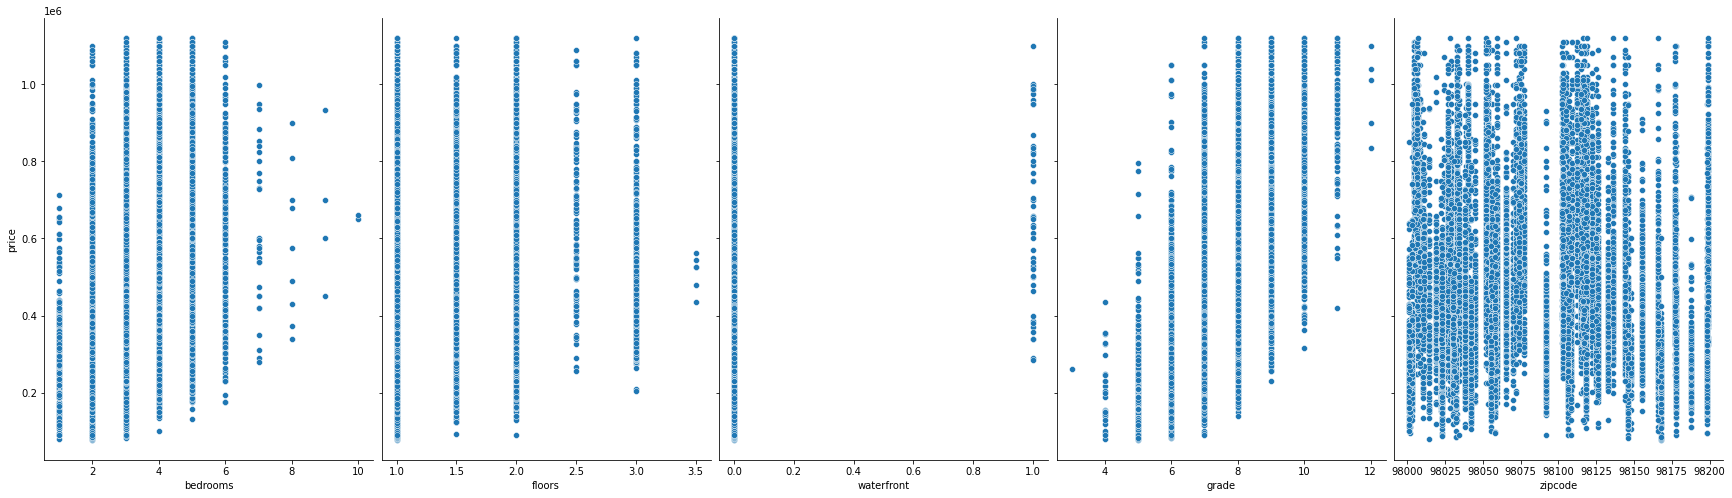

In [68]:
# discrete data: bedrooms, floors, waterfront, grade, zipcode
p = sns.pairplot(houses_df, x_vars=['bedrooms', 'floors', 'waterfront', 'grade', 'zipcode'], y_vars='price', height=7, aspect=0.7)

#### the scatterplots above produce patterns bar graph-like patterns

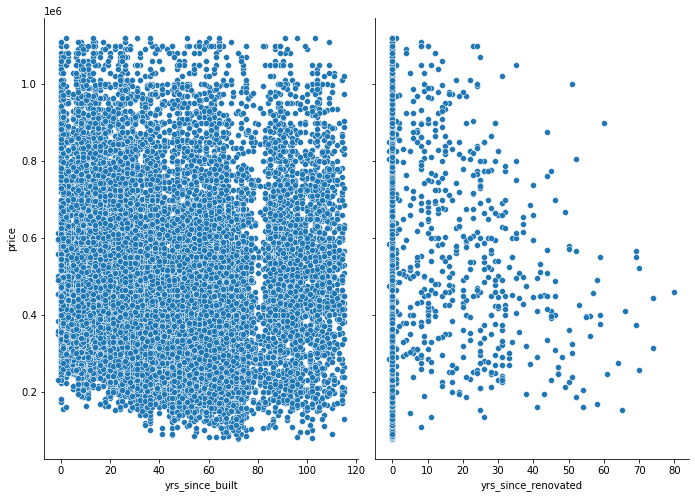

In [69]:
# discrete data: yrs_since_built, yrs_since_renovated
p = sns.pairplot(houses_df, x_vars=['yrs_since_built', 'yrs_since_renovated'], y_vars='price', height=7, aspect=0.7)

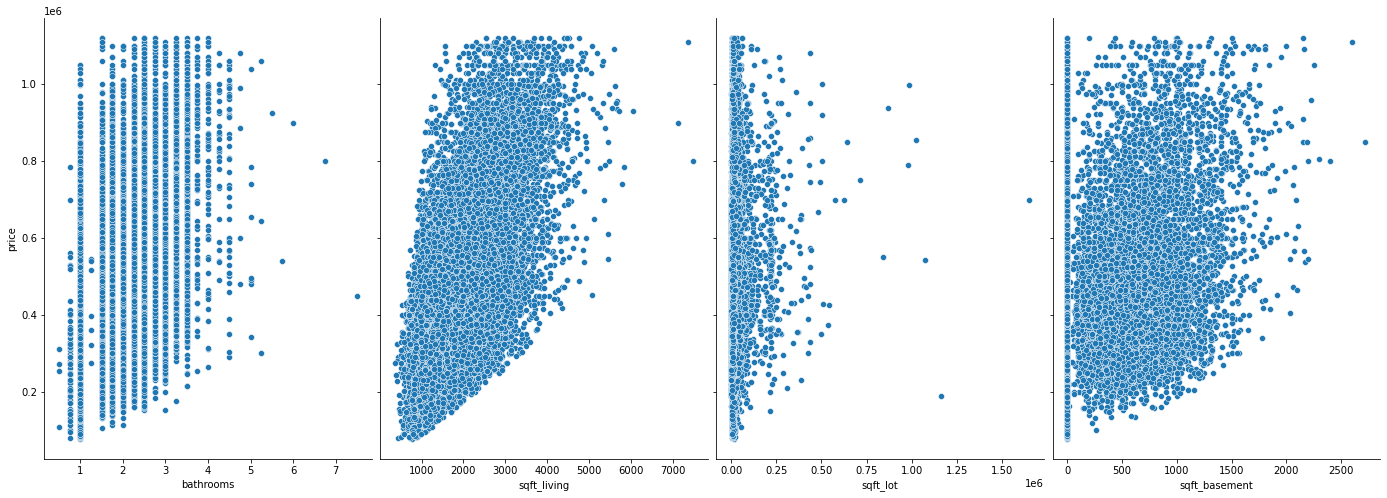

In [70]:
# continuous data: bathrooms, sqft_living, sqft_lot, sqft_basement
p = sns.pairplot(houses_df, x_vars=['bathrooms', 'sqft_living', 'sqft_lot', 'sqft_basement'], y_vars='price', height=7, aspect=0.7)

In [71]:
houses_df.corr()[['price']]

,price
id,0.010362
had_renovations,0.081227
price,1.000000
has_waterfront,0.048954
has_basement,0.160741
bedrooms,0.301320
bathrooms,0.454991
sqft_living,0.621406
sqft_lot,0.093567
floors,0.273400


#### ignore `id`, `had_renovations`, `has_basement`, `has_waterfront`, `price`, `yr_sold`, and `yr_renovated` (these columns are not assessed as predictors)

#### based on the scatterplots and negligible rho values for `sqft_lot`, `waterfront`, `yrs_since_built`, and `yrs_since_renovated`, these columns will be dropped

In [72]:
# dropping predictors with negligible rho values 
# also dropping other columns not required for the regression model
houses_df.drop(columns=['id', 'had_renovations', 'has_basement', 'has_waterfront', 
                        'yr_sold', 'yr_built', 'yr_renovated',
                        'sqft_lot', 'waterfront', 'yrs_since_built', 'yrs_since_renovated'], inplace=True)

In [73]:
# confirming dropped columns
houses_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20437 entries, 0 to 21581
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          20437 non-null  int64  
 1   bedrooms       20437 non-null  int64  
 2   bathrooms      20437 non-null  float64
 3   sqft_living    20437 non-null  int64  
 4   floors         20437 non-null  float64
 5   grade          20437 non-null  int64  
 6   sqft_basement  20437 non-null  int64  
 7   zipcode        20437 non-null  object 
 8   zipcode_cat    20437 non-null  int8   
dtypes: float64(2), int64(5), int8(1), object(1)
memory usage: 1.4+ MB


___

# Model iteration 1

#### Predictors: 
1. sqft_living
2. sqft_basement
3. bedrooms
4. bathrooms
5. floors
6. grade
7. zipcode_cat

In [74]:
y = 'price'
formula = y + '~' + 'sqft_living+sqft_basement+bedrooms+bathrooms+floors+grade+zipcode_cat'

print(formula)

price~sqft_living+sqft_basement+bedrooms+bathrooms+floors+grade+zipcode_cat


In [75]:
model = ols(formula=formula, data=houses_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     2745.
Date:                Sat, 23 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:36:26   Log-Likelihood:            -2.7246e+05
No. Observations:               20437   AIC:                         5.449e+05
Df Residuals:                   20429   BIC:                         5.450e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -3.544e+05   1.02e+04    -34.703      0.000   -3.74e+05   -3.34e+05
sqft_living     101.9075      2.645     38.521      0.000      96.722     107.093
sqft_basement    41.3466      3.306     12.506      0.000      34.866      47.827
bedrooms       -1.07e+04   1531.139     -6.989      0.000   -1.37e+04   -7699.604
bathrooms     -1.564e+04   2395.050     -6.530      0.000   -2.03e+04   -1.09e+04
floors         6067.7008   2651.862      2.288      0.022     869.838    1.13e+04
grade          8.392e+04   1560.109     53.794      0.000    8.09e+04     8.7e+04
zipcode_cat    1292.0033     57.187     22.592      0.000    1179.912    1404.095
==============================================================================
Omnibus:                     1400.005   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1816.405
Skew:                           0.628   Prob(JB):                         0.00
Kurtosis:                       3.745   Cond. No.                     2.12e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

___

# Regression diagnostics

## Normality

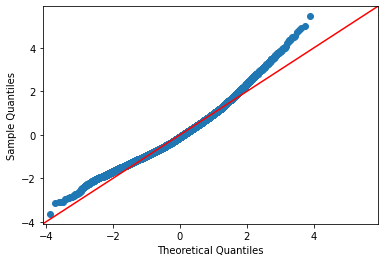

In [76]:
# generating residual QQ plot
resid = model.resid
fig = sm.graphics.qqplot(resid, dist=stats.norm, line='45', fit=True)

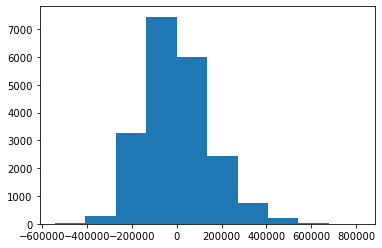

In [77]:
plt.hist(resid)
plt.show()

#### the distribution looks approximately normal

___

## Homoscedasticity

In [78]:
# conducting the Breusch-Pagan test 
# H0: homoscedasticity is present (which fits the assumption for linear regression)
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'f p-value']
 
test_result = sms.het_breuschpagan(model.resid, model.model.exog)
print(list(zip(names, test_result)))

[('Lagrange multiplier statistic', 571.5954163553524), ('p-value', 3.176912782723713e-119), ('f-value', 83.97313970451327), ('f p-value', 6.055377320092107e-121)]


#### the results of the Breusch-Pagan test imply a significant lack of homoscedasticity. however - as seen through the scatterplots earlier - this may be driven by the discrete predictors

#### it's worth further inspecting the residual plots for each predictor individually

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


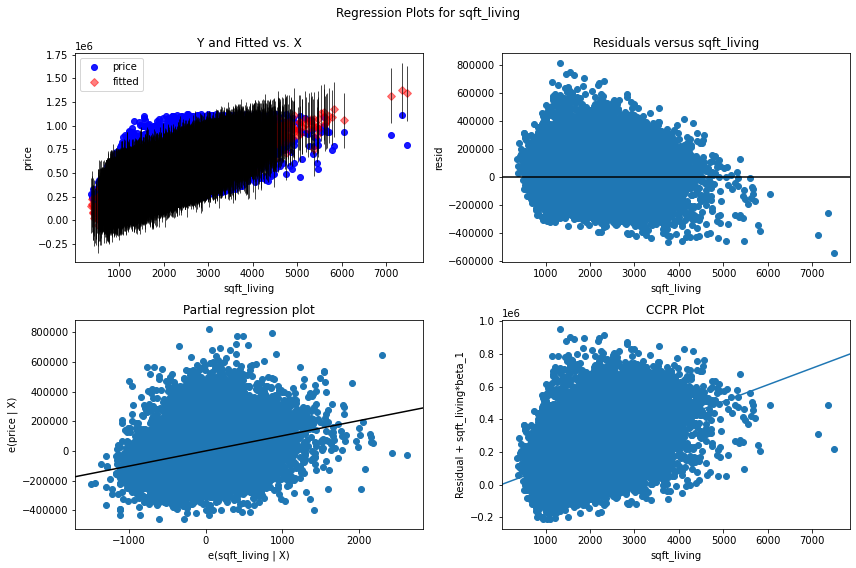

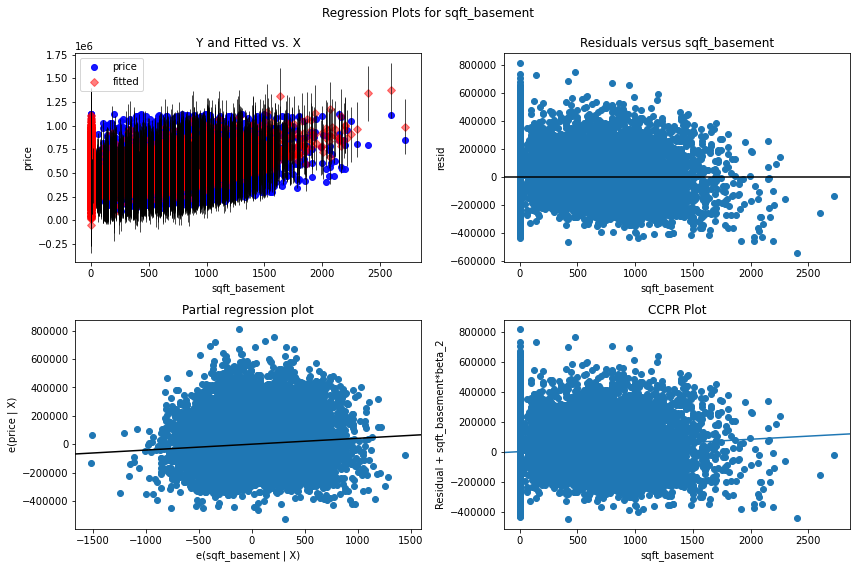

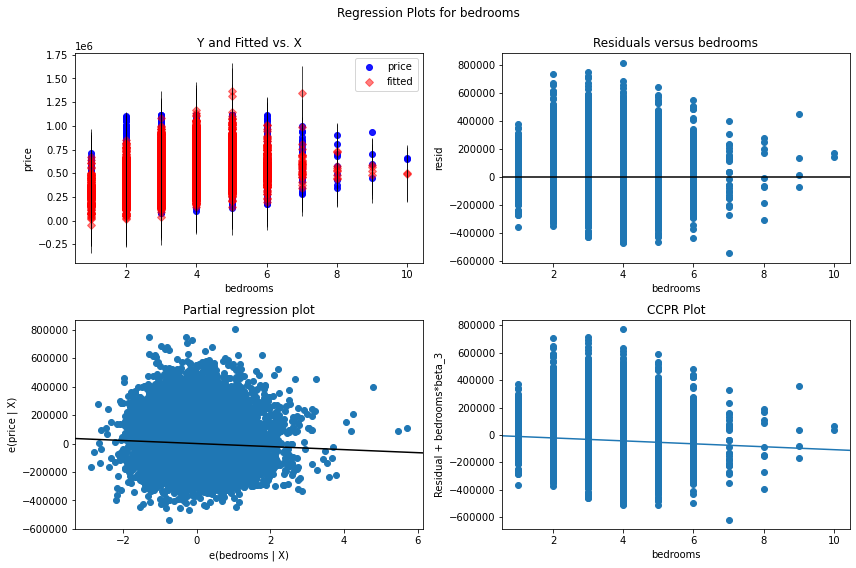

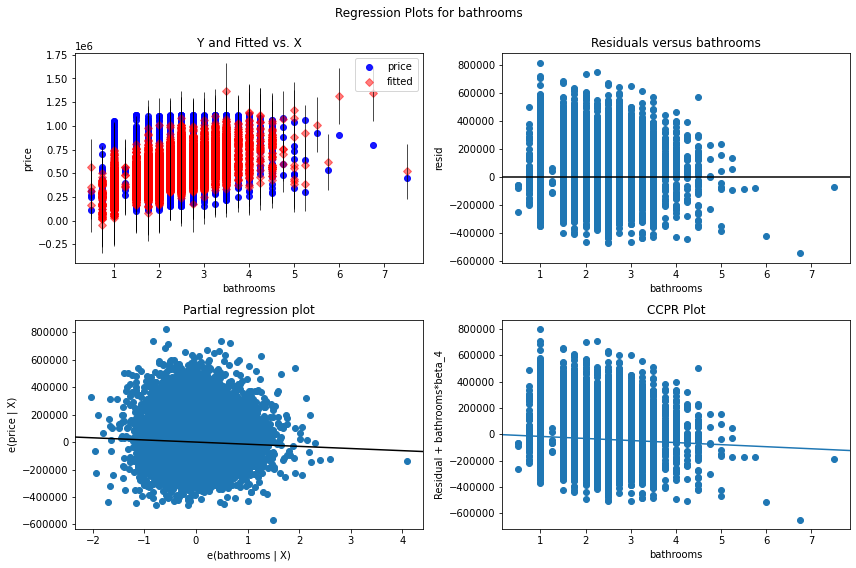

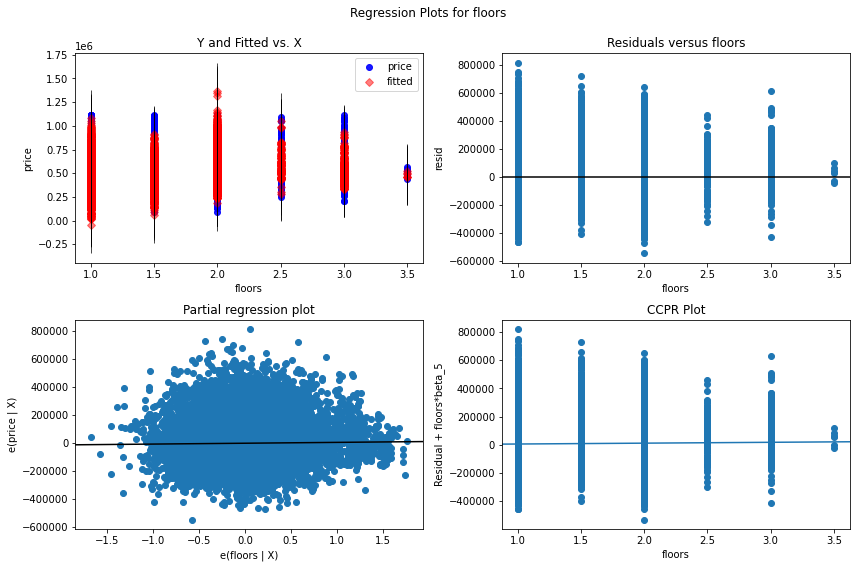

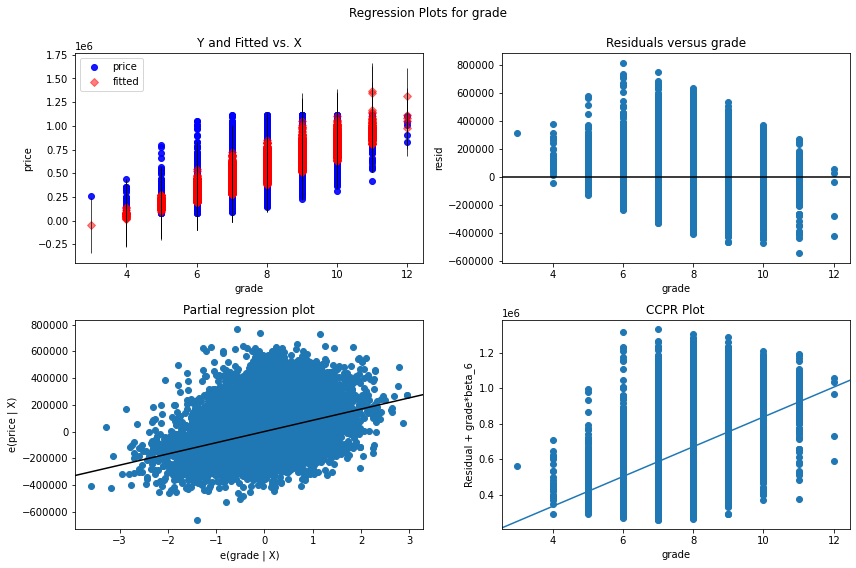

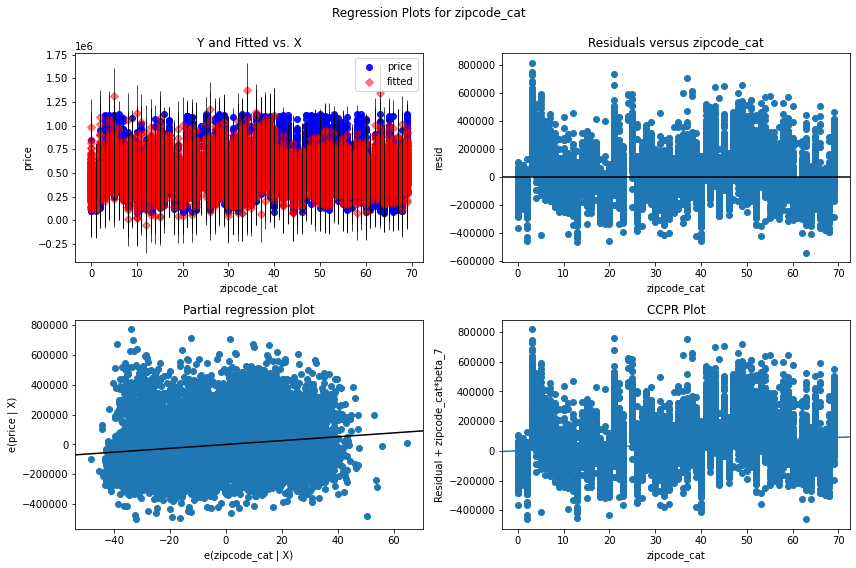

In [79]:
for i in ['sqft_living', 'sqft_basement', 'bedrooms',
         'bathrooms', 'floors', 'grade', 'zipcode_cat']:
    # define the figure size
    fig = plt.figure(figsize=(12,8))

    # generate the regression plots
    fig = sm.graphics.plot_regress_exog(model, i, fig=fig)

#### clear patterns are seen within the discrete variables - it would be best to treat them as categorical predictors, and one-hot encode these columns 

#### excluding the clustering on 0 for `sqft_basement` (not all houses have a basement), the residual plots show no clear patterns for the continuous variables 

___

## Multicollinearity

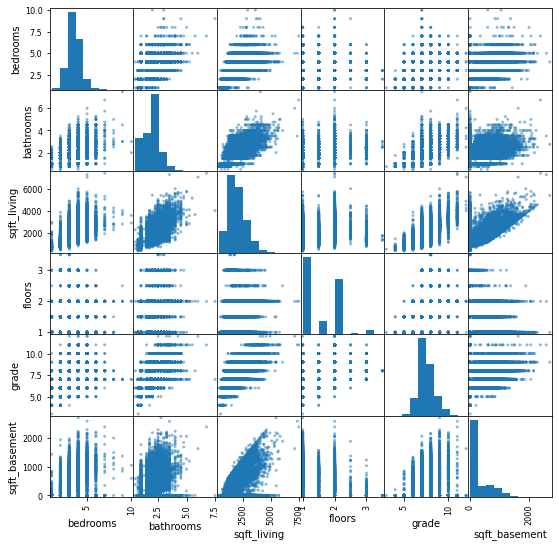

In [80]:
predictors = houses_df[['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'grade', 'sqft_basement']]

pd.plotting.scatter_matrix(predictors,figsize  = [9, 9]);
plt.show()

In [81]:
predictors.corr()

,bedrooms,bathrooms,sqft_living,floors,grade,sqft_basement
bedrooms,1.000000,0.505079,0.602027,0.160700,0.329874,0.281722
bathrooms,0.505079,1.000000,0.716673,0.502671,0.614022,0.216782
sqft_living,0.602027,0.716673,1.000000,0.340465,0.705288,0.369099
floors,0.160700,0.502671,0.340465,1.000000,0.457610,-0.291990
grade,0.329874,0.614022,0.705288,0.457610,1.000000,0.070230
sqft_basement,0.281722,0.216782,0.369099,-0.291990,0.070230,1.000000


#### there's a high correlation between `sqft_living` and (1) `grade`, (2) `bathrooms`. applying a threshold of r = |0.7|, `sqft_living` will be dropped

In [82]:
houses_df.drop(columns=['sqft_living'], inplace=True)

____

# One-hot encoding categorical variables

1. bathrooms
2. bedrooms 
3. floors
4. grade
5. zipcode

In [83]:
# create column 'bathroom_cat' with 8 categories 
houses_df['bathroom_cat'] = pd.cut(x=houses_df['bathrooms'], bins=[0,1,2,3,4,5,6,7,8], 
                     labels=['under_1', '2', '3', '4', '5',
                            '6', '7', 'over_7'])

In [84]:
# dummy code bathroom
bath_dum = pd.get_dummies(houses_df['bathroom_cat'], drop_first=True)

# rename columns
bath_dict = dict()
for i in list(bath_dum.columns):
    bath_dict[i] = "bath_{}".format(i)
    
bath_dum.rename(columns=bath_dict, inplace=True)

# append to df
houses_df = houses_df.join(bath_dum)

In [85]:
# dummy code bedroom
bed_dum = pd.get_dummies(houses_df['bedrooms'], drop_first=True)

# rename columns
bed_dict = dict()
for i in list(bed_dum.columns):
    bed_dict[i] = "bed_{}".format(i)

bed_dum.rename(columns=bed_dict, inplace=True)

# append to df
houses_df = houses_df.join(bed_dum)

In [86]:
# create a loop for the remaining variables
# ignore FutureWarning
dum_df_dict = dict()

for col in ['floors', 'grade', 'zipcode']:
    # get dummy df 
    dum_df = pd.get_dummies(houses_df[col], drop_first=True)
    
    # rename columns in dummy df 
    col_dict = dict()
    for i in list(dum_df.columns):
        col_dict[i] = "{}_{}".format(col, i)
        
    dum_df.rename(columns=col_dict, inplace=True)
    
    # add to dict
    dum_df_dict[col] = dum_df

In [87]:
for k,v in dum_df_dict.items():
    houses_df = houses_df.join(v)

In [88]:
houses_df.head()

,price,bedrooms,bathrooms,floors,grade,sqft_basement,zipcode,zipcode_cat,bathroom_cat,bath_2,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,262000,1,0.75,1.0,3,0,98022,12,under_1,0,...,0,0,0,0,0,0,0,0,0,0
1,299000,1,0.75,1.0,4,0,98014,10,under_1,0,...,0,0,0,0,0,0,0,0,0,0
2,80000,1,0.75,1.0,4,0,98014,10,under_1,0,...,0,0,0,0,0,0,0,0,0,0
3,140000,1,1.00,1.0,4,0,98055,30,under_1,0,...,0,0,0,0,0,0,0,0,0,0
4,355000,1,0.75,1.0,4,0,98074,37,under_1,0,...,0,0,0,0,0,0,0,0,0,0


In [89]:
# OLS doesn't support decimal points in the formula, thus columns need to be renamed
houses_df.rename(columns={'floors_1.5':'floors_1pt5', 'floors_2.0':'floors_2',
                         'floors_2.5':'floors_2pt5', 'floors_3.0':'floors_3',
                          'floors_3.5':'floors_3pt5'}, inplace=True)

___

# Model iteration 2

In [90]:
y = 'price'
x = houses_df.drop(columns=['price', 'bedrooms', 'bathrooms', 'bathroom_cat',
                           'floors', 'grade', 'zipcode'])

x_sum = '+'.join(x.columns)
formula = y + '~' + x_sum

print(formula)

price~sqft_basement+zipcode_cat+bath_2+bath_3+bath_4+bath_5+bath_6+bath_7+bath_over_7+bed_2+bed_3+bed_4+bed_5+bed_6+bed_7+bed_8+bed_9+bed_10+floors_1pt5+floors_2+floors_2pt5+floors_3+floors_3pt5+grade_4+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+zipcode_98002+zipcode_98003+zipcode_98004+zipcode_98005+zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010+zipcode_98011+zipcode_98014+zipcode_98019+zipcode_98022+zipcode_98023+zipcode_98024+zipcode_98027+zipcode_98028+zipcode_98029+zipcode_98030+zipcode_98031+zipcode_98032+zipcode_98033+zipcode_98034+zipcode_98038+zipcode_98039+zipcode_98040+zipcode_98042+zipcode_98045+zipcode_98052+zipcode_98053+zipcode_98055+zipcode_98056+zipcode_98058+zipcode_98059+zipcode_98065+zipcode_98070+zipcode_98072+zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092+zipcode_98102+zipcode_98103+zipcode_98105+zipcode_98106+zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112+zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118+zi

In [91]:
model = ols(formula=formula, data=houses_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     649.8
Date:                Sat, 23 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:36:44   Log-Likelihood:            -2.6458e+05
No. Observations:               20437   AIC:                         5.294e+05
Df Residuals:                   20336   BIC:                         5.302e+05
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.122e+05   1.02e+05      2.079      0.038    1.21e+04    4.12e+05
sqft_basement    47.1427      2.259     20.864      0.000      42.714      51.571
zipcode_cat    4100.6132    118.282     34.668      0.000    3868.770    4332.456
bath_2         2.109e+04   2443.157      8.634      0.000    1.63e+04    2.59e+04
bath_3         4.726e+04   3062.384     15.434      0.000    4.13e+04    5.33e+04
bath_4         9.848e+04   4671.897     21.080      0.000    8.93e+04    1.08e+05
bath_5         1.296e+05   1.15e+04     11.246      0.000    1.07e+05    1.52e+05
bath_6         6.858e+04   4.28e+04      1.603      0.109   -1.53e+04    1.52e+05
bath_7        -9.401e+04   1.04e+05     -0.901      0.368   -2.99e+05    1.11e+05
bath_over_7   -4.198e+04   1.18e+05     -0.356      0.722   -2.73e+05    1.89e+05
bed_2          1.999e+04   7745.932      2.581      0.010    4809.235    3.52e+04
bed_3          4.611e+04   7749.479      5.950      0.000    3.09e+04    6.13e+04
bed_4          7.697e+04   7883.622      9.764      0.000    6.15e+04    9.24e+04
bed_5          8.323e+04   8328.616      9.993      0.000    6.69e+04    9.96e+04
bed_6          9.592e+04   1.04e+04      9.187      0.000    7.55e+04    1.16e+05
bed_7           6.14e+04   2.06e+04      2.974      0.003    2.09e+04    1.02e+05
bed_8          4.145e+04   3.49e+04      1.186      0.236   -2.71e+04     1.1e+05
bed_9          1.187e+05   5.97e+04      1.989      0.047    1721.352    2.36e+05
bed_10         1.093e+05   7.25e+04      1.507      0.132   -3.29e+04    2.51e+05
floors_1pt5    4.408e+04   2790.463     15.798      0.000    3.86e+04    4.96e+04
floors_2       2683.1091   2367.468      1.133      0.257   -1957.319    7323.537
floors_2pt5    1.324e+04      1e+04      1.322      0.186   -6384.622    3.29e+04
floors_3      -9.652e+04   5145.801    -18.757      0.000   -1.07e+05   -8.64e+04
floors_3pt5   -9.095e+04   4.17e+04     -2.180      0.029   -1.73e+05   -9172.943
grade_4       -1.176e+05   1.04e+05     -1.132      0.258   -3.21e+05    8.61e+04
grade_5       -1.199e+05   1.02e+05     -1.172      0.241    -3.2e+05    8.07e+04
grade_6       -1.042e+05   1.02e+05     -1.020      0.308   -3.05e+05    9.61e+04
grade_7       -6.476e+04   1.02e+05     -0.634      0.526   -2.65e+05    1.36e+05
grade_8        1.356e+04   1.02e+05      0.133      0.894   -1.87e+05    2.14e+05
grade_9        1.448e+05   1.02e+05      1.416      0.157   -5.56e+04    3.45e+05
grade_10       2.381e+05   1.02e+05      2.327      0.020    3.76e+04    4.39e+05
grade_11        3.69e+05   1.03e+05      3.595      0.000    1.68e+05     5.7e+05
grade_12       3.918e+05   1.12e+05      3.489      0.000    1.72e+05    6.12e+05
zipcode_98002  1734.0835   8938.822      0.194      0.846   -1.58e+04    1.93e+04
zipcode_98003 -1.315e+04   7962.803     -1.651   

#### the skewness and kurtosis values are both high, indicating the distribution is skewed and features a strong peak

___

# Data standardisation and transformation

In [92]:
# square root transform the continuous variables
houses_df['sqrt_price'] = np.sqrt(houses_df['price'])
houses_df['sqrt_sqft_basement'] = np.sqrt(houses_df['sqft_basement'])

In [93]:
# standardising the continous predictor
basement = houses_df['sqrt_sqft_basement']
scaled_basement = (basement - np.mean(basement)) / np.sqrt(np.var(basement))

houses_df['sqrt_sqft_basement_z'] = scaled_basement

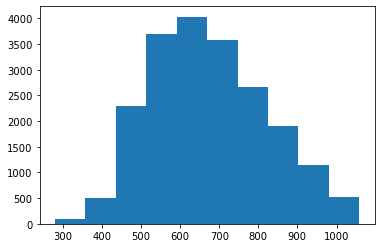

In [94]:
# checking distributions after standardisation and sqrt transformation
plt.hist(houses_df['sqrt_price'])
plt.show()

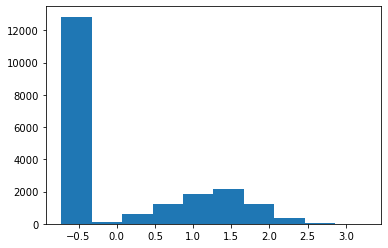

In [95]:
plt.hist(houses_df['sqrt_sqft_basement_z'])
plt.show()

#### ignoring the strong peak at -0.5 for the scaled and standardised version `sqrt_basement` (caused by houses with no basements), both distributions appear approximately normally distributed

___

# Model iteration 3

In [96]:
y = 'sqrt_price'
x = houses_df.drop(columns=['price', 'sqrt_price', 'bedrooms', 'bathrooms', 'bathroom_cat',
                           'floors', 'grade', 'zipcode', 'sqft_basement', 'sqrt_sqft_basement', 'zipcode_cat'])

x_sum = '+'.join(x.columns)
formula = y + '~' + x_sum

print(formula)

sqrt_price~bath_2+bath_3+bath_4+bath_5+bath_6+bath_7+bath_over_7+bed_2+bed_3+bed_4+bed_5+bed_6+bed_7+bed_8+bed_9+bed_10+floors_1pt5+floors_2+floors_2pt5+floors_3+floors_3pt5+grade_4+grade_5+grade_6+grade_7+grade_8+grade_9+grade_10+grade_11+grade_12+zipcode_98002+zipcode_98003+zipcode_98004+zipcode_98005+zipcode_98006+zipcode_98007+zipcode_98008+zipcode_98010+zipcode_98011+zipcode_98014+zipcode_98019+zipcode_98022+zipcode_98023+zipcode_98024+zipcode_98027+zipcode_98028+zipcode_98029+zipcode_98030+zipcode_98031+zipcode_98032+zipcode_98033+zipcode_98034+zipcode_98038+zipcode_98039+zipcode_98040+zipcode_98042+zipcode_98045+zipcode_98052+zipcode_98053+zipcode_98055+zipcode_98056+zipcode_98058+zipcode_98059+zipcode_98065+zipcode_98070+zipcode_98072+zipcode_98074+zipcode_98075+zipcode_98077+zipcode_98092+zipcode_98102+zipcode_98103+zipcode_98105+zipcode_98106+zipcode_98107+zipcode_98108+zipcode_98109+zipcode_98112+zipcode_98115+zipcode_98116+zipcode_98117+zipcode_98118+zipcode_98119+zipcode_9

In [97]:
model = ols(formula=formula, data=houses_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sqrt_price   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     700.2
Date:                Sat, 23 Sep 2023   Prob (F-statistic):               0.00
Time:                        18:36:45   Log-Likelihood:            -1.1587e+05
No. Observations:               20437   AIC:                         2.320e+05
Df Residuals:                   20336   BIC:                         2.328e+05
Df Model:                         100                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              477.5759     70.593      6.765      0.000     339.207     615.945
bath_2                  20.7552      1.698     12.226      0.000      17.428      24.083
bath_3                  42.2599      2.129     19.847      0.000      38.086      46.433
bath_4                  71.8929      3.250     22.123      0.000      65.523      78.263
bath_5                  94.4905      7.973     11.852      0.000      78.864     110.117
bath_6                  59.9497     29.592      2.026      0.043       1.946     117.953
bath_7                   3.2881     72.117      0.046      0.964    -138.067     144.644
bath_over_7            -16.2873     81.487     -0.200      0.842    -176.008     143.434
bed_2                   15.3035      5.358      2.856      0.004       4.802      25.805
bed_3                   33.4400      5.361      6.238      0.000      22.933      43.948
bed_4                   57.2525      5.452     10.500      0.000      46.565      67.940
bed_5                   63.1135      5.754     10.968      0.000      51.835      74.392
bed_6                   72.8638      7.212     10.103      0.000      58.728      87.000
bed_7                   46.9866     14.275      3.292      0.001      19.007      74.966
bed_8                   40.6569     24.160      1.683      0.092      -6.699      88.013
bed_9                   87.7561     41.255      2.127      0.033       6.894     168.618
bed_10                  90.2626     50.163      1.799      0.072      -8.061     188.586
floors_1pt5             30.1307      1.932     15.594      0.000      26.343      33.918
floors_2                -1.2181      1.634     -0.745      0.456      -4.421       1.985
floors_2pt5              4.7244      6.920      0.683      0.495      -8.839      18.288
floors_3               -72.1624      3.582    -20.147      0.000     -79.183     -65.142
floors_3pt5            -62.4792     28.862     -2.165      0.030    -119.051      -5.907
grade_4               -117.1786     71.855     -1.631      0.103    -258.021      23.664
grade_5               -108.0198     70.781     -1.526      0.127    -246.757      30.717
grade_6                -83.0996     70.693     -1.176      0.240    -221.663      55.464
grade_7                -45.7538     70.698     -0.647      0.518    -184.327      92.819
grade_8                 12.1675     70.708      0.172      0.863    -126.426     150.761
grade_9                 97.2279     70.722      1.375      0.169     -41.393     235.849
grade_10               152.5480     70.760      2.156      0.031      13.852     291.244
grade_11               224.4657     70.983      3.162      0.002      85.333     363.598
grade_12               237.4188     77.668      3.057      0.002      85.182     389.655
zipcode_98002           -2.3143      6.230     -0.371    

___

# Model validation

In [98]:
# establishing the train and test sets 
y = houses_df['sqrt_price']
x = houses_df.drop(columns=['price', 'sqrt_price', 'bedrooms', 'bathrooms', 'bathroom_cat',
                           'floors', 'grade', 'zipcode', 'sqft_basement', 'sqrt_sqft_basement', 'zipcode_cat'])

x_train, x_test, y_train, y_test = train_test_split(
  x,y , random_state=104,test_size=0.25, shuffle=True)

In [99]:
# inspecting sizes
print("Number of rows:")
print("- Pre-split total: {}".format(x.shape[0]))
print("- Training set: {}".format(x_train.shape[0]))
print("- Testing set: {}".format(x_test.shape[0]))

Number of rows:
- Pre-split total: 20437
- Training set: 15327
- Testing set: 5110


In [100]:
# creating the linear regression model
linreg = LinearRegression()
linreg.fit(x_train, y_train)

y_hat_train = linreg.predict(x_train)
y_hat_test = linreg.predict(x_test)

In [101]:
# comparing mean squared error between the train and test sets
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 4877.703148118881
Test Mean Squared Error: 5103.57106216972


#### there's minimal difference in mean squared errror (MSE) values between the training and testing sets - indicative of the absence of an overfitted model

In [102]:
# making predictions based on the model
y_pred = linreg.predict(x_test)

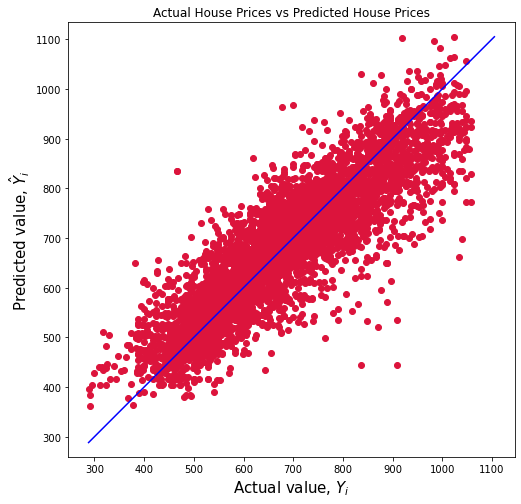

In [103]:
# plotting actual vs. predicted prices 
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_pred, c='crimson')

# adding regression line
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')

# formatting graph
plt.xlabel('Actual value, $Y_i$', fontsize=15)
plt.ylabel('Predicted value, $\hat{Y}_i$', fontsize=15)
plt.title("Actual House Prices vs Predicted House Prices")
plt.axis('equal')

plt.show()

In [104]:
# calculate R2 and adjusted R2
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
adj_r2 = 1 - (1 - r2) * (len(y_test) - 1) / (len(y_test) - len(linreg.coef_) - 1)

print(adj_r2)

0.7614161136992901


___

# Results

The full model predicts **~76% of the variability in house prices** by taking into account the following predictors: 
- Number of bedrooms
- Number of bathrooms
- Number of floors
- Basement size
- Building grade
- Zip code

Three interesting (albeit maybe a little obvious) insights in particular:
> Note: Graphs are plotted using statistically significant correlation values only (i.e., p < alpha at 0.05)

1. **In general, the greater the number of bedrooms and bathrooms, the higher the selling price**, although the model coefficients may suggest points of diminishing returns. That's to say, knocking down walls to establish anything beyond 6 bedrooms and 5 bathrooms may not be the as worth the return on investment (However, it's also important to note that the sample sizes for houses featuring over 4 bathrooms or 6 bedrooms are very small, resulting in less reliable coefficient values). Bathrooms appear to add more value to a home than bedrooms, though it's likely more costly to install one, too.

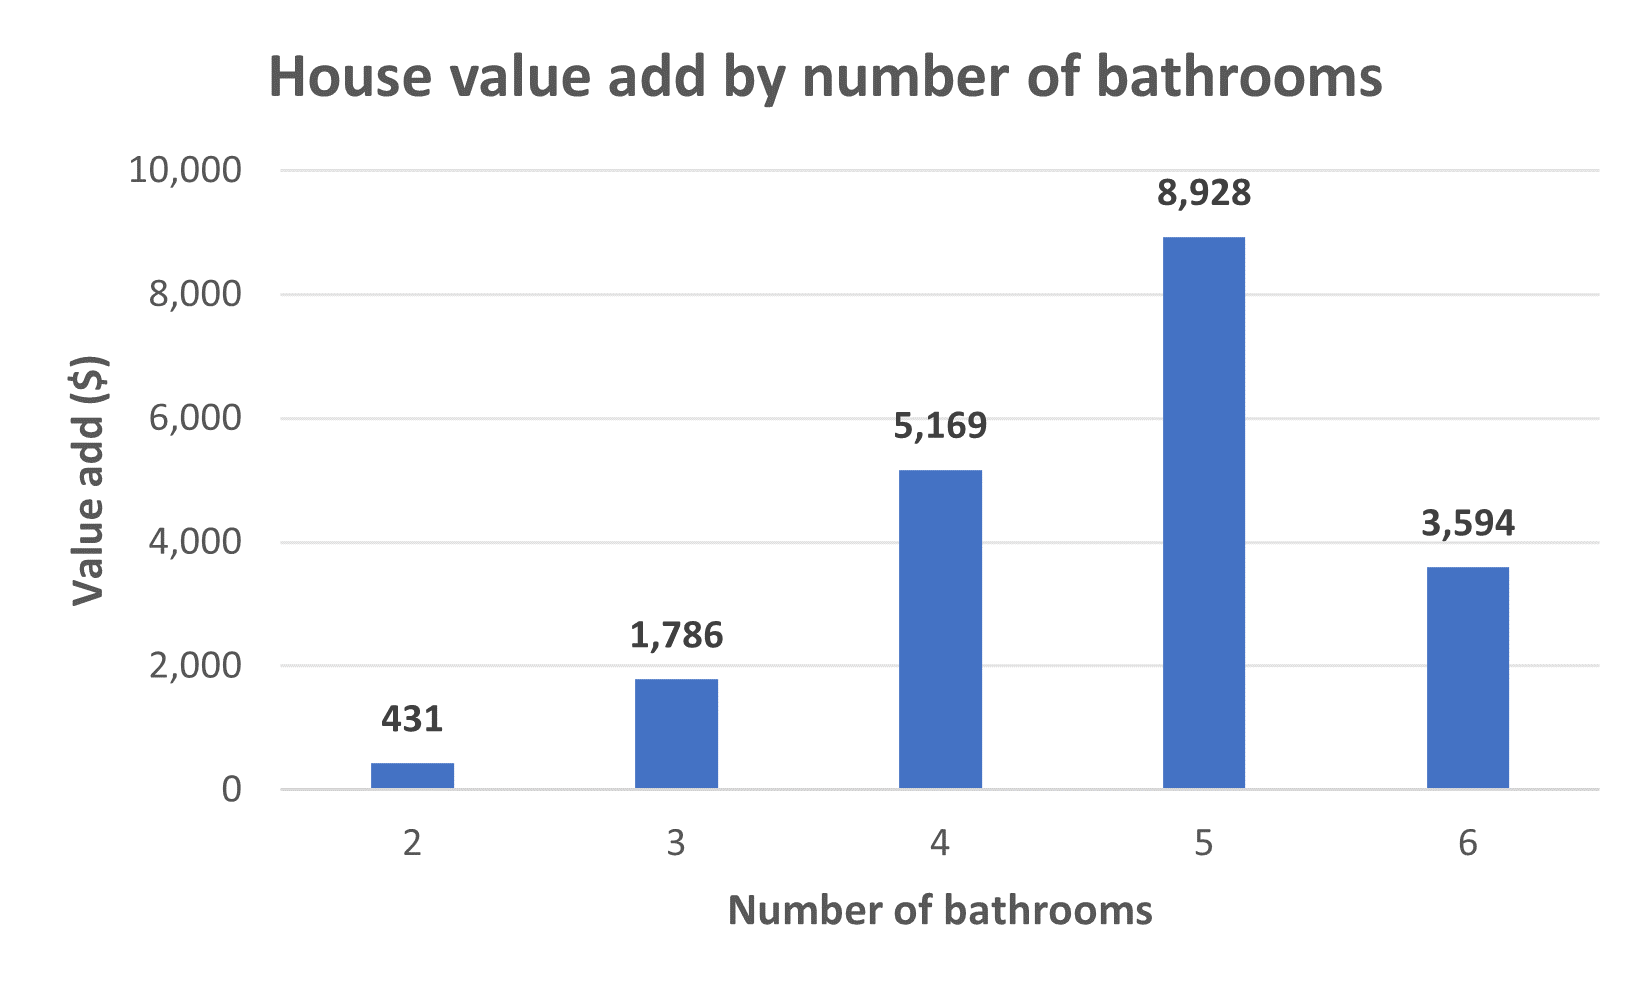

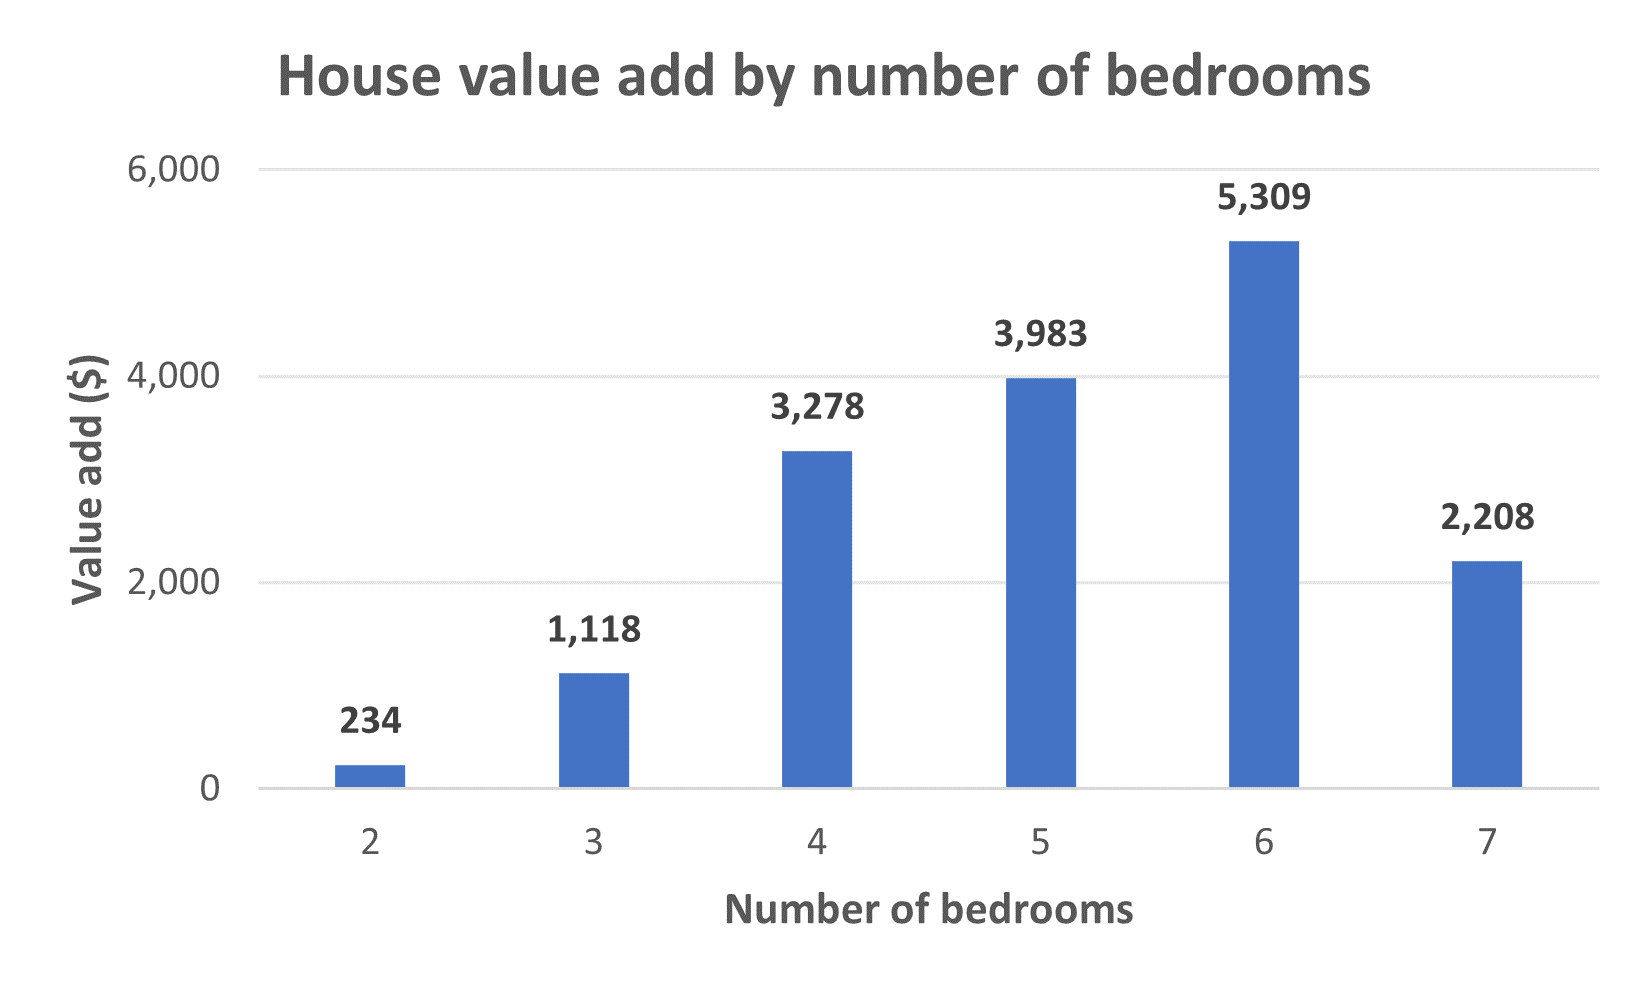

2. **Higher building grades correlate with higher selling prices**. Getting your house appraised and achieving a grade of 10 __[("high quality features")](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r)__ may reliably help your lot stand out from others in the market. Improving construction quality (e.g., better ventilation, more energy efficient fixtures) would be an easier and more accessible option, compared to building an entirely new room.

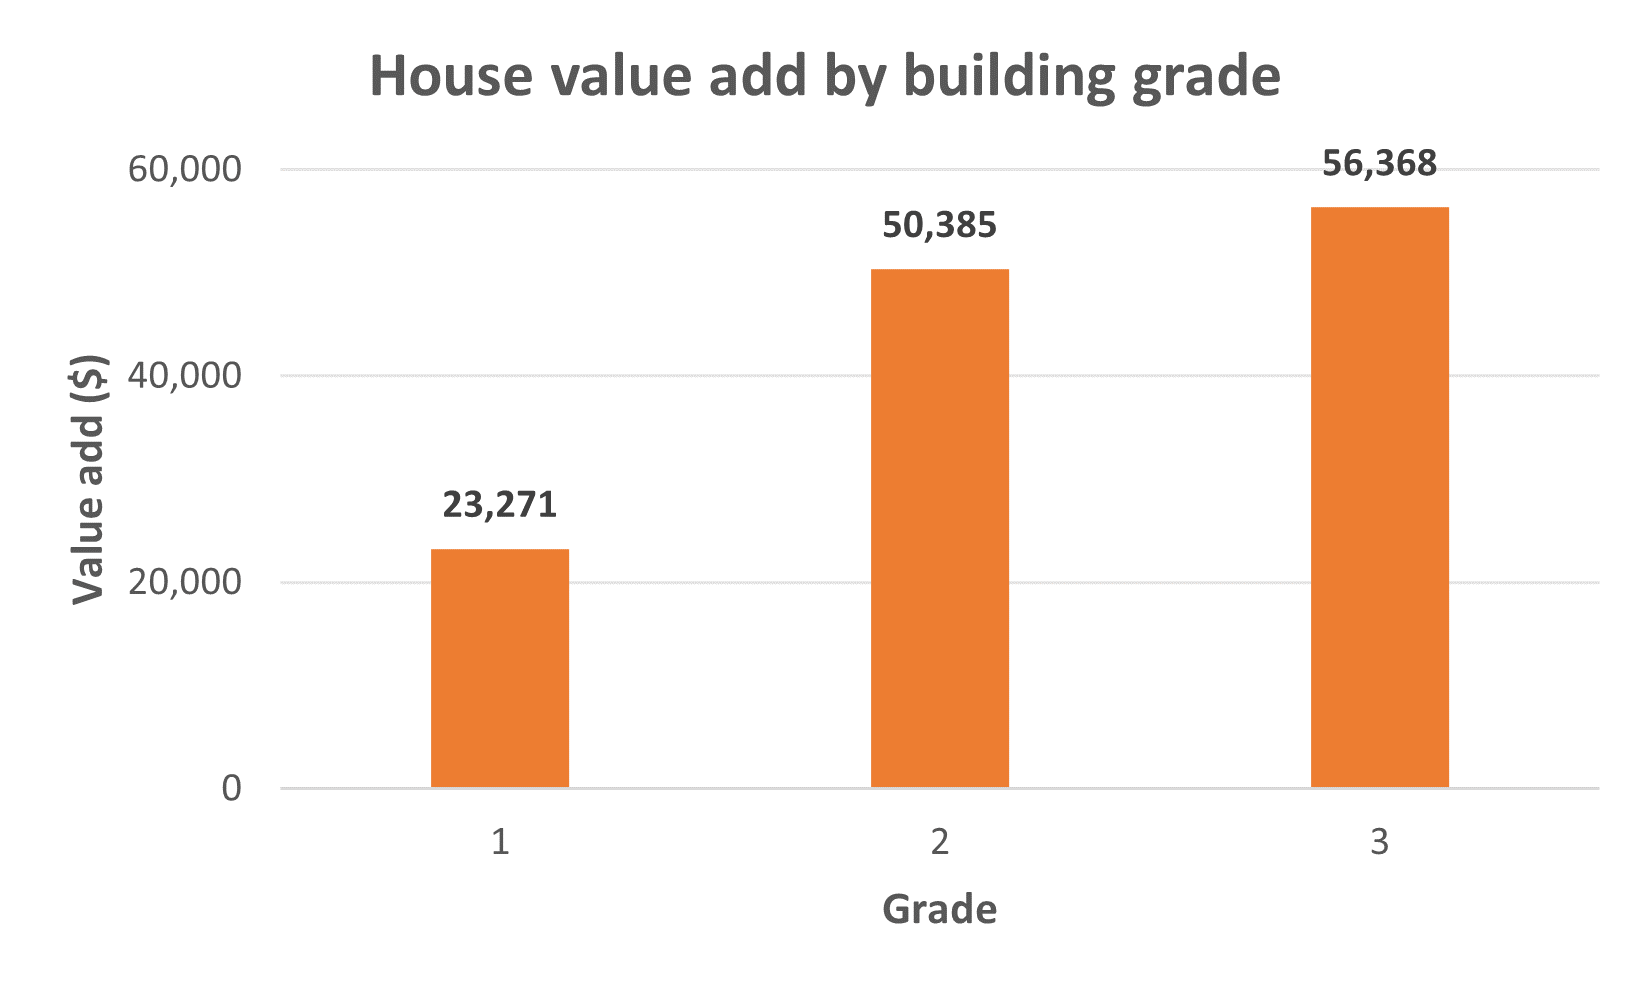

3. **Your zip code strongly informs your property price**. Vicinity to an area's central business district (e.g., 98105, 98112, 98199, which are all Seattle zip codes) or the promise of luxury living (e.g., 98039: Medina, 98040: Mercer Island, 98053: Redmond) are two factors that would account for this.

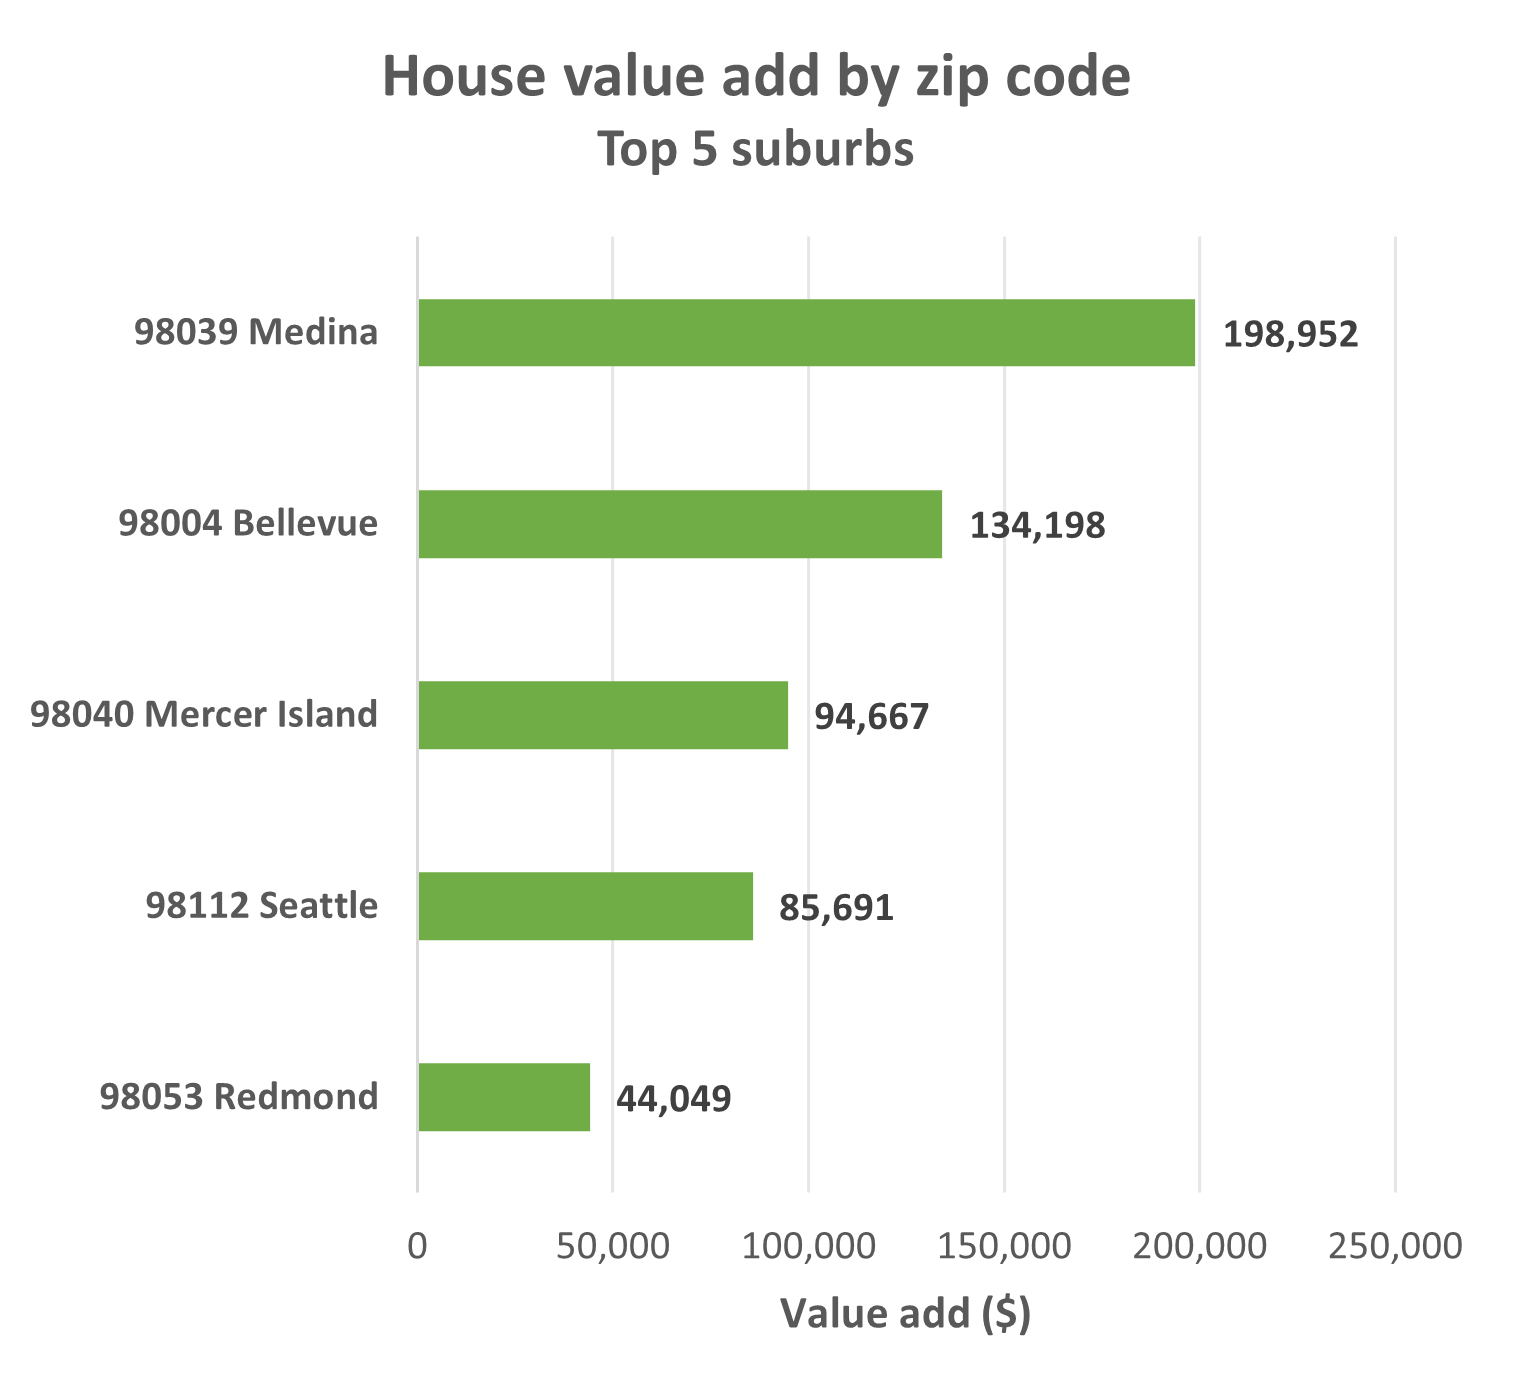

___

# Conclusion


This model isn't intended to completely determine the final sale price of a house; rather, it would hopefully be a helpful tool to help individuals garner a better idea of what their asking price may be, and how competitive their property would be relative to other lots on the market. 

___

# Next steps

1. **More rigorous and advanced modelling techniques**, such as utilising factor analysis when selecting predictors, comparing performance across linear, ridge, and lasso regression models, and implementing k-fold cross-validation techniques for better model training and evaluation.

2. **More informative house parameters**. E.g., looking at the size of bedrooms and bathrooms instead of just the number of them. (If two houses were the same size, and house A featured 5 small bathrooms while house B featured 3 large ones, would house A go for a higher price?)

3. **More neighbourhood parameters**. It would be interesting to see how the distance of a home from  facilities (e.g., schools, public transport, grocery stores) may play into that home's value. 
